In [1]:
import numpy as np
from pathlib import Path
import mat73
import matplotlib.pyplot as plt
from sklearn import decomposition
import seaborn as sns
sns.set_theme()

In [2]:
path = Path.home()/'Desktop'/'Data'/'G_Ready-Set_bin1ms_alignedReady.mat'
data = mat73.loadmat(path)
SID = 0

In [3]:
for k,v in data.items():
    if k=='wbin': continue
    if type(v[SID])==list: print(f'{k} ==> {len(v)}')
    else: print(f'{k} ==> {v[SID].shape}')

D ==> (1200, 107, 1498)
id_eye ==> (1498,)
id_left ==> (1498,)
id_neuron ==> (107, 2)
id_short ==> (1498,)
id_trial ==> (1498,)
sp_times ==> 12
t_p ==> (1498,)
t_s ==> (1498,)


In [4]:
# D = [timepoints x neurons x trials]

In [5]:
for ts in np.unique(data['t_s'][SID]):
    indices = np.where(data['t_s'][SID]==ts)
    print(f'Ts = {ts}, number of associated trials = {indices[0].shape[0]}')

Ts = 480.0, number of associated trials = 145
Ts = 560.0, number of associated trials = 149
Ts = 640.0, number of associated trials = 166
Ts = 720.0, number of associated trials = 144
Ts = 800.0, number of associated trials = 282
Ts = 900.0, number of associated trials = 185
Ts = 1000.0, number of associated trials = 133
Ts = 1100.0, number of associated trials = 159
Ts = 1200.0, number of associated trials = 135


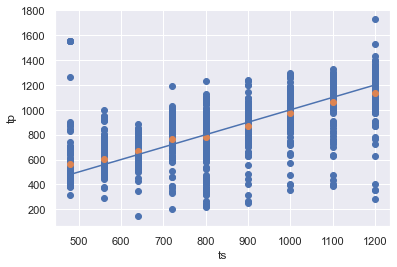

In [6]:
# Calculating tp across unique values of ts
unique_ts_tp_means = []
for ts in np.unique(data['t_s'][SID]):
    indices = np.where(data['t_s'][SID]==ts)
    unique_ts_tp_means.append(data['t_p'][SID][indices].mean())
    
plt.scatter(data['t_s'][SID], data['t_p'][SID])
plt.plot(range(480,1200), range(480,1200)) # unity line
plt.scatter(np.unique(data['t_s'][SID]), unique_ts_tp_means)
plt.xlabel('ts')
plt.ylabel('tp')
plt.show()

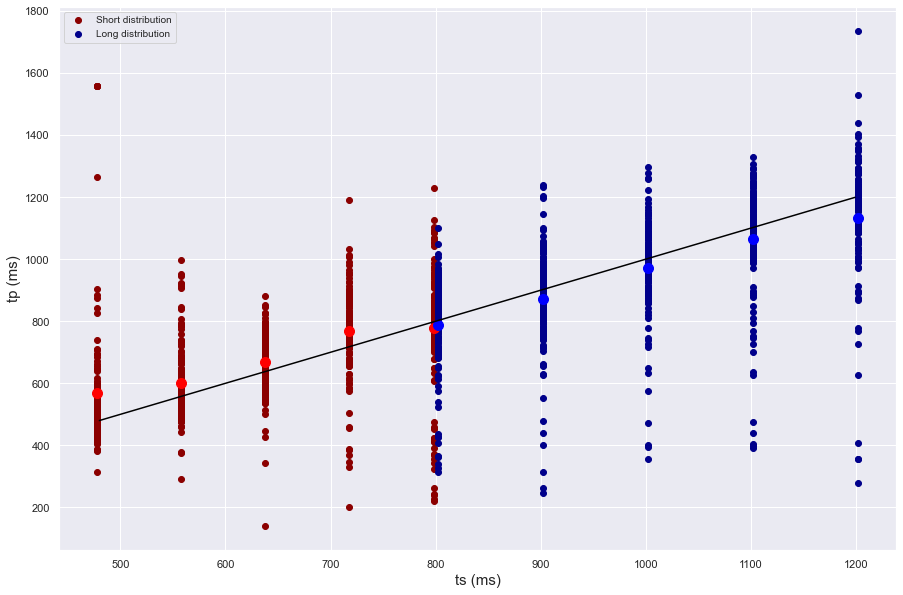

In [7]:
# Calculating tp across unique values of ts separately for the two conditions
unique_ts_short_tp_means = []
short_ts = []
unique_ts_long_tp_means = []
long_ts = []

for ts in np.unique(data['t_s'][SID]):
    indices = np.where(data['t_s'][SID]==ts)
    if ts < 800:
        short_ts.append(ts)
        unique_ts_short_tp_means.append(data['t_p'][SID][indices].mean())
    elif ts > 800:
        long_ts.append(ts)
        unique_ts_long_tp_means.append(data['t_p'][SID][indices].mean())
    else:
        short_ts.append(ts)
        long_ts.append(ts)
        indices = np.where(np.logical_and(data['t_s'][SID]==ts, data['id_short'][SID]))
        unique_ts_short_tp_means.append(data['t_p'][SID][indices].mean())
        indices = np.where(np.logical_and(data['t_s'][SID]==ts, data['id_short'][SID]==False))
        unique_ts_long_tp_means.append(data['t_p'][SID][indices].mean())
short_ts = np.array(short_ts)
long_ts = np.array(long_ts)

plt.figure(figsize=(15,10))
plt.scatter(data['t_s'][SID][np.where(data['id_short'][SID])]-2, data['t_p'][SID][np.where(data['id_short'][SID])], c='darkred') # Short distribution data
plt.scatter(data['t_s'][SID][np.where(data['id_short'][SID]==False)]+2, data['t_p'][SID][np.where(data['id_short'][SID]==False)], c='darkblue') # Long distribution data
plt.scatter(short_ts-2, unique_ts_short_tp_means, c='red', s=100) # Short means
plt.scatter(long_ts+2, unique_ts_long_tp_means, c='blue', s=100) # Long means
plt.plot(range(480,1200), range(480,1200), c='black') # unity line
plt.xlabel('ts (ms)', fontsize=15)
plt.ylabel('tp (ms)', fontsize=15)

plt.legend(['Short distribution', 'Long distribution'], fontsize=10)
plt.show()

In [8]:
data['D'][SID].shape

(1200, 107, 1498)

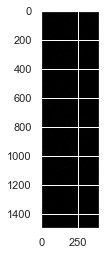

In [9]:
plt.imshow(data['D'][SID][:400,0,:].T,cmap='gray')

In [10]:
data_trimT = data['D'][SID][np.isnan(data['D'][SID][:, :, 0]).sum(axis=1)<107, :, 0]

In [11]:
data_trimT.shape

(1100, 107)

In [12]:
quality_matrix = np.zeros(data['D'][SID].shape[1:])
value_range_matrix = np.zeros(data['D'][SID].shape[1:])

for i in range(data['D'][SID].shape[1]):
    for j in range(data['D'][SID].shape[2]):
        if True in np.isnan(np.unique(data['D'][SID][:,i,j])): quality_matrix[i,j]=0
        else: quality_matrix[i,j]=1
        
        value_range_matrix[i,j] = len(np.unique(data['D'][SID][:,i,j][~np.isnan(data['D'][SID][:,i,j])]))

C:\Users\sarfi\AppData\Local\Temp\ipykernel_5832\2720991347.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(im)


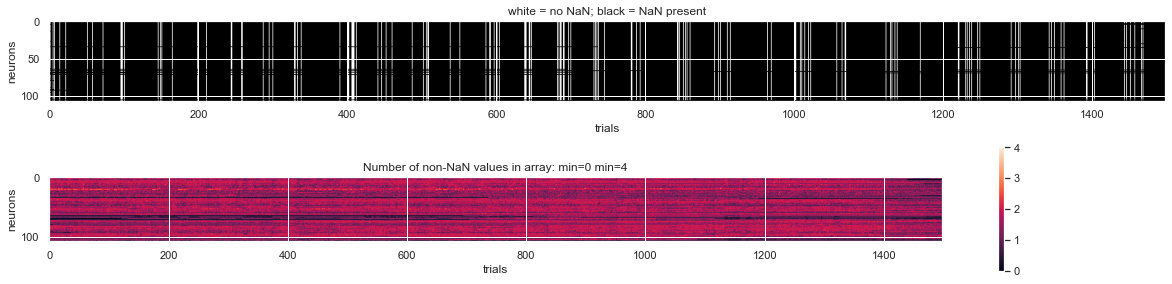

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20,5))

ax[0].imshow(quality_matrix,cmap='gray',vmin=0,vmax=1)
ax[0].set_xlabel('trials')
ax[0].set_ylabel('neurons')
ax[0].set_title('white = no NaN; black = NaN present')

im = ax[1].imshow(value_range_matrix,vmin=value_range_matrix.min(),vmax=value_range_matrix.max())
ax[1].set_xlabel('trials')
ax[1].set_ylabel('neurons')
ax[1].set_title(f'Number of non-NaN values in array: min={int(np.unique(value_range_matrix)[0])} min={int(np.unique(value_range_matrix)[-1])}')
plt.colorbar(im)

plt.show()

White vertical lines are trials of maximum possible length - 1200ms. Horizontal black lines are badly recorded neurons probably

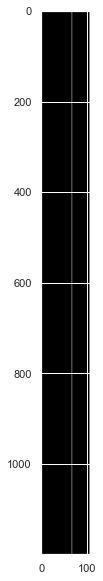

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(np.isnan(data['D'][SID][:,:,1000]),cmap='gray')

In trial 1000, which is full length (1200 ms), all neurons are non-NaN, except index 67 and 106.

In [15]:
D1000 = data['D'][SID][:,:,1000].copy()
D1000 = np.delete(D1000, 67, 1)
D1000 = np.delete(D1000, 105, 1)

D1000[D1000>0] = 1

Text(0, 0.5, 'neurons')

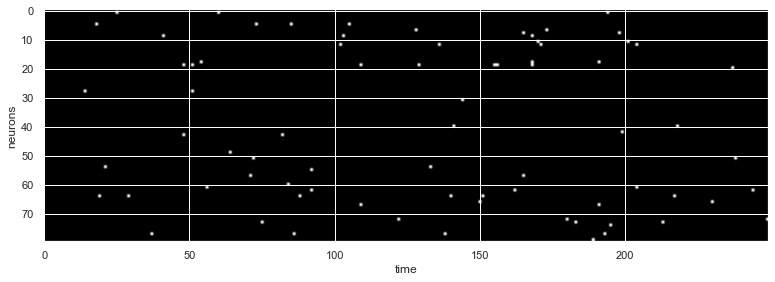

In [16]:
fig, ax = plt.subplots(figsize=(13, 10))
ax.imshow(D1000[:250,:80].T, cmap='gray')
ax.set_xlabel('time')
ax.set_ylabel('neurons')

### Firing Rate

In [17]:
DeltaT = 100 # number of time bins on which we average
dt = 20 # temporal distance between points on which we compute the firing rate

timepoints = np.arange(DeltaT, 1200+1, dt)
N_timepoints = len(timepoints)
timepoints

array([ 100,  120,  140,  160,  180,  200,  220,  240,  260,  280,  300,
        320,  340,  360,  380,  400,  420,  440,  460,  480,  500,  520,
        540,  560,  580,  600,  620,  640,  660,  680,  700,  720,  740,
        760,  780,  800,  820,  840,  860,  880,  900,  920,  940,  960,
        980, 1000, 1020, 1040, 1060, 1080, 1100, 1120, 1140, 1160, 1180,
       1200])

In [18]:
np.where(timepoints==800)[0]

array([35], dtype=int64)

In [19]:
len(timepoints[:int(np.where(timepoints==800)[0])])

35

In [20]:
fr = np.empty((N_timepoints, data['D'][SID].shape[1])) * np.nan
# N_short_timepoints = len(timepoints[:int(np.where(timepoints==800)[0])]) # limit the number of timepoints by maximum Short distribution interval
short_fr = np.empty((N_timepoints, data['D'][SID].shape[1])) * np.nan
long_fr = np.empty((N_timepoints, data['D'][SID].shape[1])) * np.nan

for i_timepoint, timepoint in enumerate(timepoints):
    # Collapse [time x trials] matrix of each neurons (with unequal length trials) into [time x 1] matrix with average number of spikes over 1ms bins (as in original dataset)
    mean_over_trials = np.nanmean(data['D'][SID], axis=2)
    # Compute firing rate by sliding the window of length defined above
    fr[i_timepoint, :] = np.nansum(mean_over_trials[(timepoint-DeltaT):timepoint, :], axis=0) / (DeltaT/1000)
    
    # if i_timepoint < N_short_timepoints:
    # The same but selecting Short trials
    indices = np.where(data['id_short'][SID])
    mean_over_trials_short = np.nanmean(data['D'][SID][:,:,indices], axis=-1)[:,:,0]
    short_fr[i_timepoint, :] = np.nansum(mean_over_trials_short[(timepoint-DeltaT):timepoint, :], axis=0) / (DeltaT/1000)
    
    # The same but selecting Long trials
    indices = np.where(~data['id_short'][SID])
    mean_over_trials_long = np.nanmean(data['D'][SID][:,:,indices], axis=-1)[:,:,0]
    long_fr[i_timepoint, :] = np.nansum(mean_over_trials_long[(timepoint-DeltaT):timepoint, :], axis=0) / (DeltaT/1000)

C:\Users\sarfi\AppData\Local\Temp\ipykernel_5832\357496082.py:15: RuntimeWarning: Mean of empty slice
  mean_over_trials_short = np.nanmean(data['D'][SID][:,:,indices], axis=-1)[:,:,0]


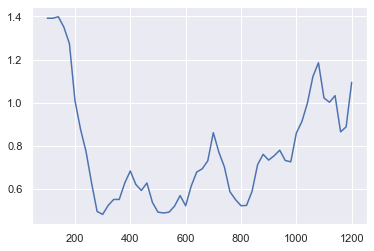

In [21]:
# plt.plot(timepoints, np.mean(fr[:, 2, :], axis=-1))
plt.plot(timepoints, fr[:, 4])

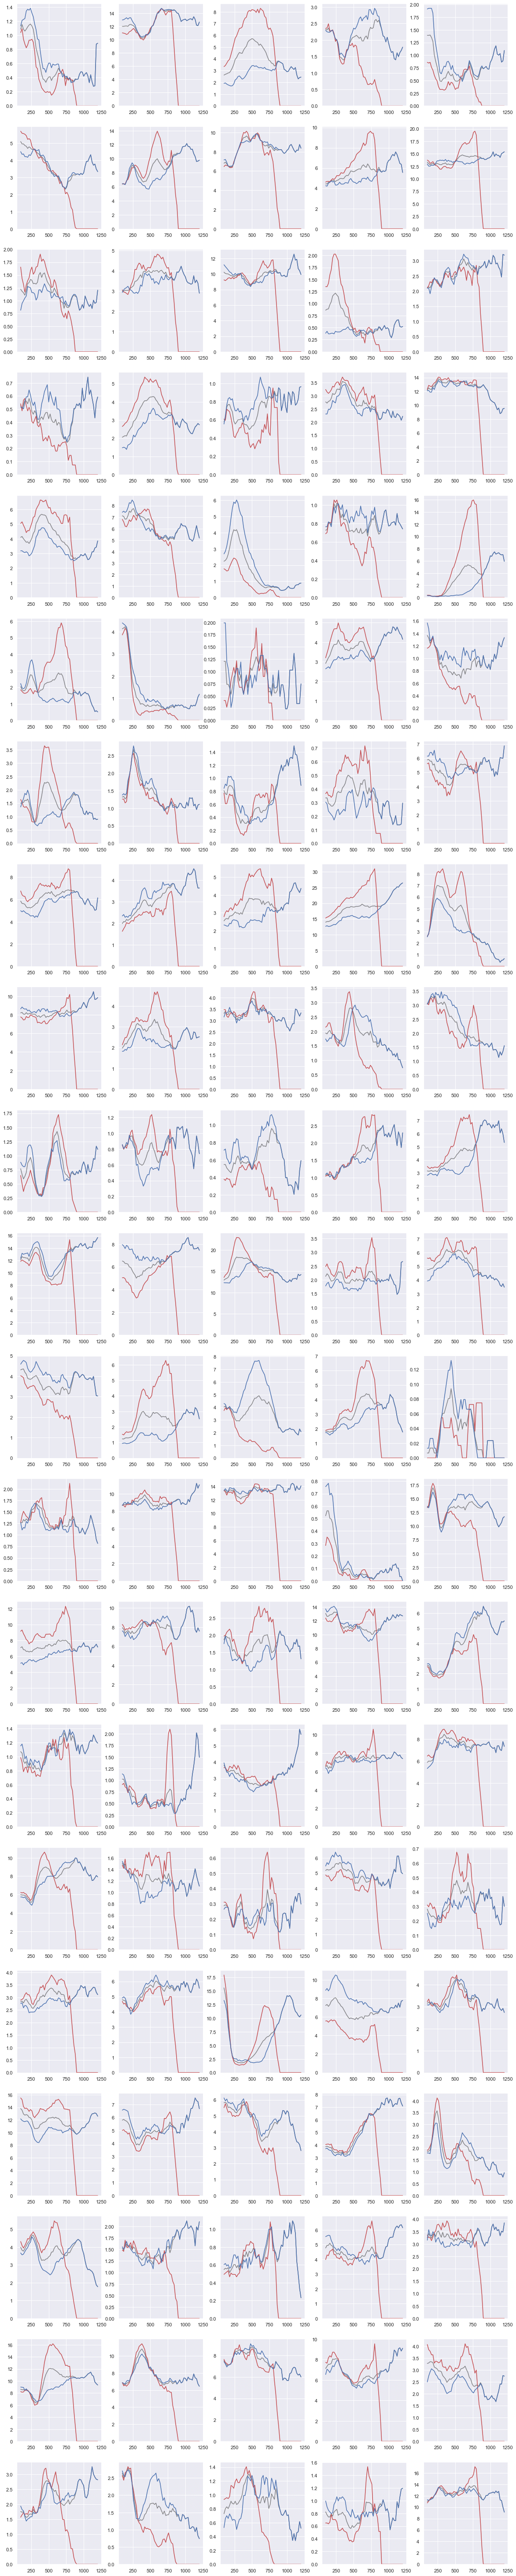

In [22]:
N_neurons_cols = int(np.sqrt(107)/2)
fig, axs = plt.subplots(107//N_neurons_cols, N_neurons_cols, figsize=(20, 107))
for i_neuron, ax in enumerate(axs.ravel()):
    ax.plot(timepoints, fr[:, i_neuron], 'k', alpha=.5)
    ax.plot(timepoints, short_fr[:, i_neuron], 'r')
    ax.plot(timepoints, long_fr[:, i_neuron], 'b')
    ax.set_ylim(0)

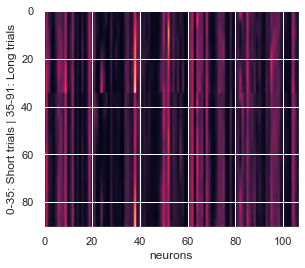

In [23]:
plt.imshow(np.vstack((short_fr[:35,:],long_fr)))
plt.xlabel('neurons',fontsize=12)
plt.ylabel('0-35: Short trials | 35-91: Long trials', fontsize=12)
plt.show()

In [24]:
pca = decomposition.PCA(n_components=2)
x_pca = pca.fit_transform(np.vstack((short_fr[:35,:],long_fr)))

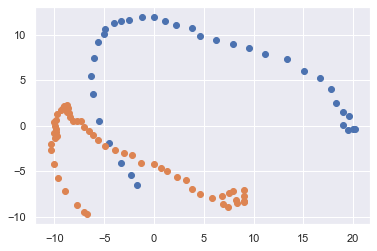

In [25]:
plt.scatter(x_pca[:35,0], x_pca[:35,1])
plt.scatter(x_pca[35:,0], x_pca[35:,1])
plt.show()

In [26]:
pca = decomposition.PCA(n_components=3)
x_pca = pca.fit_transform(np.vstack((short_fr[:35,:],long_fr)))

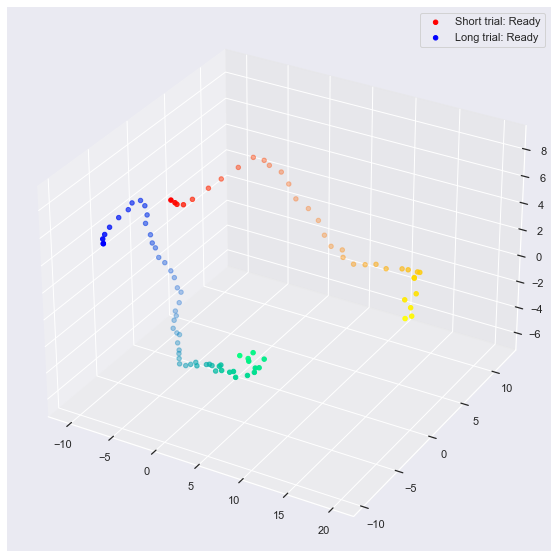

In [27]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection="3d")

c_short = range(35)
c_long = range(56)

ax.scatter(x_pca[:35,0], x_pca[:35,1], x_pca[:35,2], c=c_short, cmap='autumn')
ax.scatter(x_pca[35:,0], x_pca[35:,1], x_pca[35:,2], c=c_long, cmap='winter')

ax.legend(['Short trial: Ready', 'Long trial: Ready'])

plt.show()